## **Airbnb Reviews: Sentiment Analysis**

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore")
import nltk
from langdetect import detect
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from wordcloud import WordCloud
from PIL import Image
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
import pickle
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\win10\AppData\Roaming\nltk_data...


### Read from pickle

In [2]:
df = pd.read_pickle('lemmatize_df.pickle')

In [3]:
df.shape

(83796, 9)

In [5]:
df.dtypes

listing_id           int64
id                   int64
date                object
reviewer_id          int64
reviewer_name       object
comments            object
tokenized           object
lemmatized          object
lemmatize_joined    object
dtype: object

In [12]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,tokenized,lemmatized,lemmatize_joined,negative,neutral
0,7202016,38917982,2015-07-19,28943674,Bianca,cute and cozy place perfect location to everyt...,"[cute, and, cozy, place, perfect, location, to...","[cute, and, cozy, place, perfect, location, to...",cute and cozy place perfect location to everyt...,0.000,0.472
1,7202016,39087409,2015-07-20,32440555,Frank,kelly ha great room in very central location b...,"[kelly, ha, great, room, in, very, central, lo...","[kelly, ha, great, room, in, very, central, lo...",kelly ha great room in very central location b...,0.000,0.593
2,7202016,39820030,2015-07-26,37722850,Ian,very spacious apartment and in great neighborh...,"[very, spacious, apartment, and, in, great, ne...","[very, spacious, apartment, and, in, great, ne...",very spacious apartment and in great neighborh...,0.043,0.775
3,7202016,40813543,2015-08-02,33671805,George,close to seattle center and all it ha to offer...,"[close, to, seattle, center, and, all, it, ha,...","[close, to, seattle, center, and, all, it, ha,...",close to seattle center and all it ha to offer...,0.052,0.714
4,7202016,41986501,2015-08-10,34959538,Ming,kelly wa great host and very accommodating in ...,"[kelly, wa, great, host, and, very, accommodat...","[kelly, wa, great, host, and, very, accommodat...",kelly wa great host and very accommodate in gr...,0.000,0.602


In [13]:
df['lemmatize_joined'].head()

0    cute and cozy place perfect location to everyt...
1    kelly ha great room in very central location b...
2    very spacious apartment and in great neighborh...
3    close to seattle center and all it ha to offer...
4    kelly wa great host and very accommodate in gr...
Name: lemmatize_joined, dtype: object

## Sentiment Analysis

In [10]:
# calling the function
sia = SentimentIntensityAnalyzer()

> #### Create columns for sentiment analysis (positive, negative, and neutral)

In [14]:

df['negative'] = df['lemmatize_joined'].apply(lambda x : sia.polarity_scores(x)['neg'])
df['neutral'] = df['lemmatize_joined'].apply(lambda x : sia.polarity_scores(x)['neu'])
df['positive'] = df['lemmatize_joined'].apply(lambda x : sia.polarity_scores(x)['pos'])
df['compound'] = df['lemmatize_joined'].apply(lambda x : sia.polarity_scores(x)['compound'])

> Negative reviews are those having a sentiment of less than -0.4. Positive sentiment has a polarity larger than 0.4, while neutral sentiment has a polarity between -0.4 and 0.4.

In [91]:
# Counting the positive, negative and neutral reviews :
positive_reviews = np.sum(i > 0.4 for i in df['compound'])
neutral_reviews = np.sum(-0.4 < i < 0.4 for i in df['compound'])
negative_reviews = np.sum(i < -0.4 for i in df['compound'])
n = len(df['compound'])

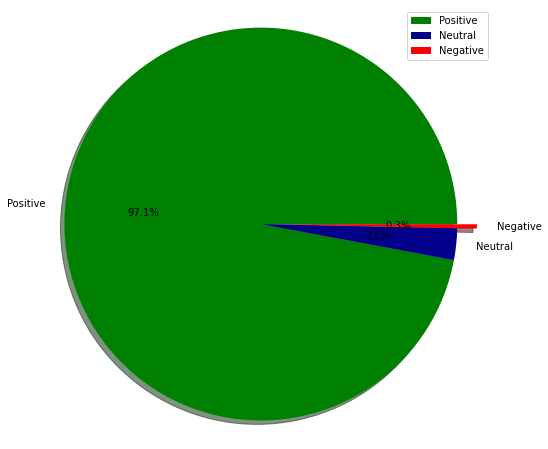

In [92]:
# Visualizing the percentage of positive, negative and neutral reviews
labels = 'Positive', 'Neutral', 'Negative'
sizes = [(positive_reviews * 100)/n, (neutral_reviews * 100)/n, (negative_reviews * 100)/n]
colors = ['green', 'darkblue', 'red']
explode = (0, 0, 0.1)  
plt.figure(figsize =(8,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.axis('equal') 
plt.legend()
plt.show()

In [93]:
positive_reviews


81335

In [94]:
neutral_reviews

2168

In [95]:
negative_reviews

293

In [102]:
df.head(10)

,listing_id,id,date,reviewer_id,reviewer_name,comments,tokenized,lemmatized,lemmatize_joined,negative,neutral,positive,compound,polarity_decode
0,7202016,38917982,2015-07-19,28943674,Bianca,cute and cozy place perfect location to everyt...,"[cute, and, cozy, place, perfect, location, to...","[cute, and, cozy, place, perfect, location, to...",cute and cozy place perfect location to everyt...,0.000,0.472,0.528,0.7717,Positive
1,7202016,39087409,2015-07-20,32440555,Frank,kelly ha great room in very central location b...,"[kelly, ha, great, room, in, very, central, lo...","[kelly, ha, great, room, in, very, central, lo...",kelly ha great room in very central location b...,0.000,0.596,0.404,0.9875,Positive
2,7202016,39820030,2015-07-26,37722850,Ian,very spacious apartment and in great neighborh...,"[very, spacious, apartment, and, in, great, ne...","[very, spacious, apartment, and, in, great, ne...",very spacious apartment and in great neighborh...,0.043,0.775,0.182,0.8625,Neutral
3,7202016,40813543,2015-08-02,33671805,George,close to seattle center and all it ha to offer...,"[close, to, seattle, center, and, all, it, ha,...","[close, to, seattle, center, and, all, it, ha,...",close to seattle center and all it ha to offer...,0.051,0.709,0.239,0.8622,Neutral
4,7202016,41986501,2015-08-10,34959538,Ming,kelly wa great host and very accommodating in ...,"[kelly, wa, great, host, and, very, accommodat...","[kelly, wa, great, host, and, very, accommodat...",kelly wa great host and very accommodate in gr...,0.000,0.602,0.398,0.9831,Neutral
5,7202016,43979139,2015-08-23,1154501,Barent,kelly wa great place wa great just what wa loo...,"[kelly, wa, great, place, wa, great, just, wha...","[kelly, wa, great, place, wa, great, just, wha...",kelly wa great place wa great just what wa loo...,0.000,0.612,0.388,0.9349,Neutral
6,7202016,45265631,2015-09-01,37853266,Kevin,kelly wa great very nice and the neighborhood ...,"[kelly, wa, great, very, nice, and, the, neigh...","[kelly, wa, great, very, nice, and, the, neigh...",kelly wa great very nice and the neighborhood ...,0.000,0.552,0.448,0.9392,Positive
7,7202016,46749120,2015-09-13,24445447,Rick,hola all bnb erz just left seattle where had s...,"[hola, all, bnb, erz, just, left, seattle, whe...","[hola, all, bnb, erz, just, leave, seattle, wh...",hola all bnb erz just leave seattle where have...,0.059,0.641,0.300,0.9628,Neutral
8,7202016,47783346,2015-09-21,249583,Todd,kelly place is conveniently located on quiet s...,"[kelly, place, is, conveniently, located, on, ...","[kelly, place, be, conveniently, locate, on, q...",kelly place be conveniently locate on quiet st...,0.077,0.785,0.138,0.6705,Neutral
9,7202016,48388999,2015-09-26,38110731,Tatiana,the place wa really nice clean and the most im...,"[the, place, wa, really, nice, clean, and, the...","[the, place, wa, really, nice, clean, and, the...",the place wa really nice clean and the most im...,0.039,0.771,0.189,0.8108,Neutral


> #### classify each review with the polarity decode

In [103]:
def polarity_decode(text):
    if  sia.polarity_scores(text)['pos'] > 0.4 : 
        value = 'Positive' 
    elif sia.polarity_scores(text)['neg'] < -0.4 : 
        value =  "Negative"

    else : 
        value = "Neutral"
    return value

In [104]:
df['polarity_decode'] = df['lemmatize_joined'].apply(polarity_decode)

In [105]:
df.head(50)

,listing_id,id,date,reviewer_id,reviewer_name,comments,tokenized,lemmatized,lemmatize_joined,negative,neutral,positive,compound,polarity_decode
0,7202016,38917982,2015-07-19,28943674,Bianca,cute and cozy place perfect location to everyt...,"[cute, and, cozy, place, perfect, location, to...","[cute, and, cozy, place, perfect, location, to...",cute and cozy place perfect location to everyt...,0.000,0.472,0.528,0.7717,Positive
1,7202016,39087409,2015-07-20,32440555,Frank,kelly ha great room in very central location b...,"[kelly, ha, great, room, in, very, central, lo...","[kelly, ha, great, room, in, very, central, lo...",kelly ha great room in very central location b...,0.000,0.596,0.404,0.9875,Positive
2,7202016,39820030,2015-07-26,37722850,Ian,very spacious apartment and in great neighborh...,"[very, spacious, apartment, and, in, great, ne...","[very, spacious, apartment, and, in, great, ne...",very spacious apartment and in great neighborh...,0.043,0.775,0.182,0.8625,Neutral
3,7202016,40813543,2015-08-02,33671805,George,close to seattle center and all it ha to offer...,"[close, to, seattle, center, and, all, it, ha,...","[close, to, seattle, center, and, all, it, ha,...",close to seattle center and all it ha to offer...,0.051,0.709,0.239,0.8622,Neutral
4,7202016,41986501,2015-08-10,34959538,Ming,kelly wa great host and very accommodating in ...,"[kelly, wa, great, host, and, very, accommodat...","[kelly, wa, great, host, and, very, accommodat...",kelly wa great host and very accommodate in gr...,0.000,0.602,0.398,0.9831,Neutral
5,7202016,43979139,2015-08-23,1154501,Barent,kelly wa great place wa great just what wa loo...,"[kelly, wa, great, place, wa, great, just, wha...","[kelly, wa, great, place, wa, great, just, wha...",kelly wa great place wa great just what wa loo...,0.000,0.612,0.388,0.9349,Neutral
6,7202016,45265631,2015-09-01,37853266,Kevin,kelly wa great very nice and the neighborhood ...,"[kelly, wa, great, very, nice, and, the, neigh...","[kelly, wa, great, very, nice, and, the, neigh...",kelly wa great very nice and the neighborhood ...,0.000,0.552,0.448,0.9392,Positive
7,7202016,46749120,2015-09-13,24445447,Rick,hola all bnb erz just left seattle where had s...,"[hola, all, bnb, erz, just, left, seattle, whe...","[hola, all, bnb, erz, just, leave, seattle, wh...",hola all bnb erz just leave seattle where have...,0.059,0.641,0.300,0.9628,Neutral
8,7202016,47783346,2015-09-21,249583,Todd,kelly place is conveniently located on quiet s...,"[kelly, place, is, conveniently, located, on, ...","[kelly, place, be, conveniently, locate, on, q...",kelly place be conveniently locate on quiet st...,0.077,0.785,0.138,0.6705,Neutral
9,7202016,48388999,2015-09-26,38110731,Tatiana,the place wa really nice clean and the most im...,"[the, place, wa, really, nice, clean, and, the...","[the, place, wa, really, nice, clean, and, the...",the place wa really nice clean and the most im...,0.039,0.771,0.189,0.8108,Neutral


> **In conclusion**, negative reviews are barely there with 293 reviews only!, maybe because the data was gathered from a source which they cleaned the negative reviews, so maybe we will add to the future work that we scrape Airbnb reviews by ourselves so we can get a good resualt.